In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U transformers accelerate bitsandbytes
!pip install git+https://github.com/huggingface/peft
!pip install kobert-transformers
!pip install konlpy
!pip install xgboost
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
  Cloning https://github.com/huggingface/peft to /tmp/pip-req-build-1w18tgno
  Runn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, Trainer, TrainingArguments
from peft import LoraConfig, TaskType, get_peft_model
from kobert_transformers import get_tokenizer
from kobert_transformers import get_kobert_model
from konlpy.tag import Okt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import gradio as gr

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. 모델 학습용 데이터셋 구성

In [5]:
# AICC Data Load -> 회귀모델용
aicc_dataset = pd.read_csv('/content/drive/MyDrive/KT/AI프로토타이핑팀/aicc_dataset.csv')

In [21]:
aicc_dataset.head(1)

,no,date,category,project,customer,company,rank,budget,bid_price,price_score,tech_score,total_score,price_score_origin,price_score_max,tech_score_origin
0,1,2024-06-18,AICC,대한지방행정공제회 AI기반 스마트 컨택센터 구축 용역,대한지방행정공제회,(주)이씨에스텔레콤,1,2.530000e+09,NaN,92.73,94.3,94.143,9.273,10.0,84.87


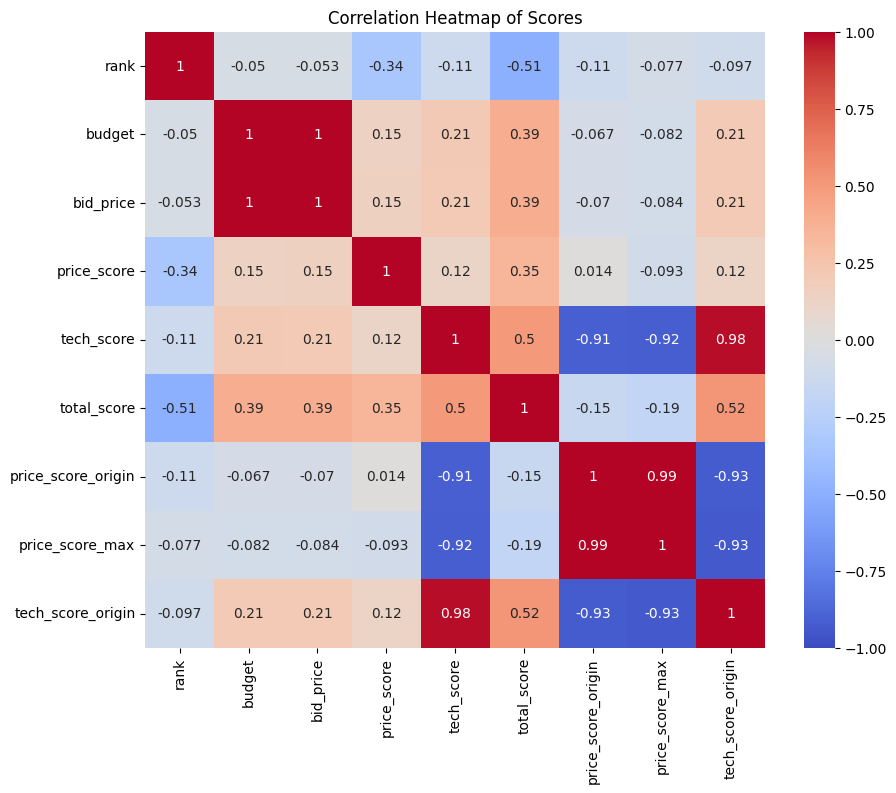

In [22]:
# 데이터 분석 -> heatmap
numeric_cols = aicc_dataset[['rank','budget','bid_price','price_score', 'tech_score', 'total_score', 'price_score_origin', 'price_score_max', 'tech_score_origin']]
numeric_cols_clean = numeric_cols.dropna()
corr_matrix = numeric_cols_clean.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Scores')
plt.show()

상관계수 (Correlation): 0.05035799806640406
공분산 (Covariance): 9.87913574189634
회귀 분석 결과: 기울기(Slope): 0.0400984863921729, 절편(Intercept): 85.53095189504484


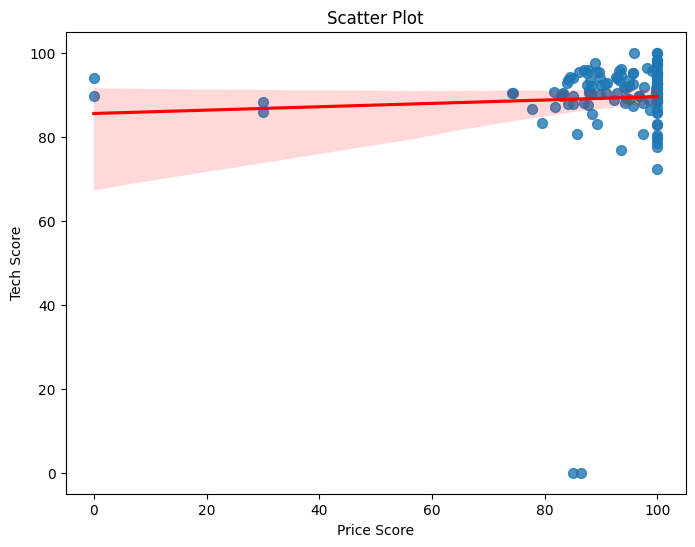

In [25]:
from scipy.stats import pearsonr, linregress

x = aicc_dataset['price_score']  # 첫 번째 수치형 변수
y = aicc_dataset['tech_score']   # 두 번째 수치형 변수

# 1. 상관계수 계산 (Pearson 상관계수)
corr, _ = pearsonr(x.dropna(), y.dropna())
print(f"상관계수 (Correlation): {corr}")

# 2. 공분산 계산
covariance = x.cov(y)
print(f"공분산 (Covariance): {covariance}")

# 3. 회귀 분석 및 회귀선 계산
slope, intercept, r_value, p_value, std_err = linregress(x.dropna(), y.dropna())
print(f"회귀 분석 결과: 기울기(Slope): {slope}, 절편(Intercept): {intercept}")

# 4. 시각화: 산점도와 회귀선
plt.figure(figsize=(8, 6))
sns.regplot(x=x, y=y, scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Scatter Plot')
plt.xlabel('Price Score')
plt.ylabel('Tech Score')
plt.show()

In [6]:
# Useless Column Drop
aicc_dataset = aicc_dataset.drop(columns=['price_score_origin', 'tech_score_origin'])

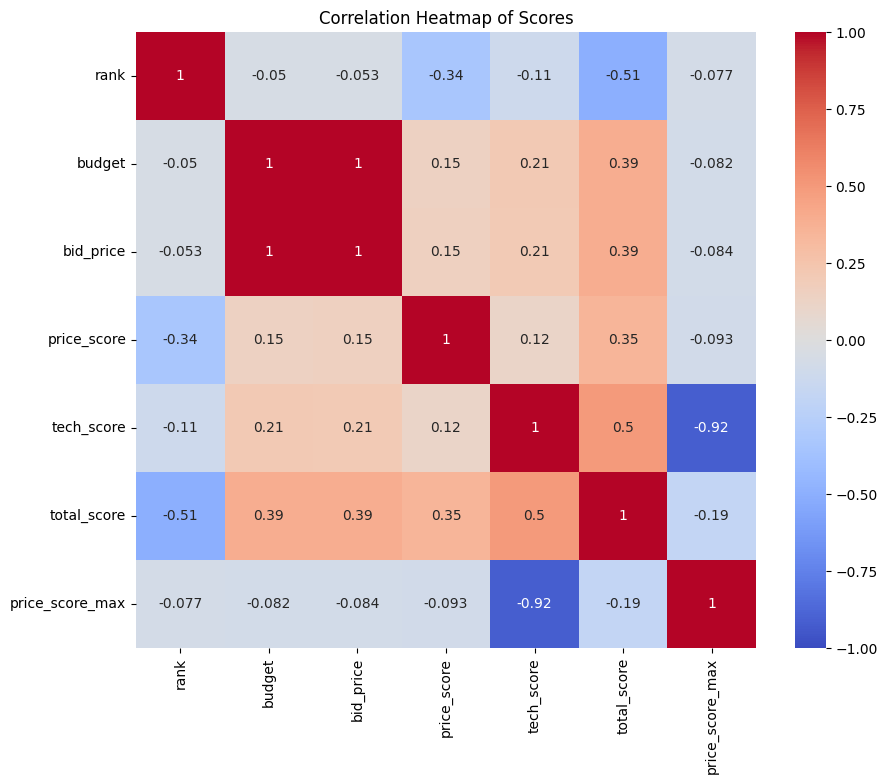

In [14]:
# 데이터 분석2 -> heatmap
numeric_cols = aicc_dataset[['rank','budget','bid_price','price_score', 'tech_score', 'total_score', 'price_score_max']]
numeric_cols_clean = numeric_cols.dropna()
corr_matrix = numeric_cols_clean.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Scores')
plt.show()

In [15]:
aicc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   no                  142 non-null    int64  
 1   date                142 non-null    object 
 2   category            142 non-null    object 
 3   project             142 non-null    object 
 4   customer            142 non-null    object 
 5   company             142 non-null    object 
 6   rank                142 non-null    int64  
 7   budget              137 non-null    float64
 8   bid_price           125 non-null    float64
 9   price_score         124 non-null    float64
 10  tech_score          124 non-null    float64
 11  total_score         124 non-null    float64
 12  price_score_origin  124 non-null    float64
 13  price_score_max     124 non-null    float64
 14  tech_score_origin   124 non-null    float64
dtypes: float64(8), int64(2), object(5)
memory usage: 16.8+ KB

**Null 값 채우기**
* budget, bid_price, price_score, tech_score 컬럼의 null값을 KNN으로 추론
* X features에 범주형, 수치형이 혼합되어 있어 다중회귀가 아닌 KNN 모델을 선택

In [30]:
aicc_dataset.dropna(inplace=True)
aicc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 7 to 141
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   no                  107 non-null    int64  
 1   date                107 non-null    object 
 2   category            107 non-null    object 
 3   project             107 non-null    object 
 4   customer            107 non-null    object 
 5   company             107 non-null    object 
 6   rank                107 non-null    int64  
 7   budget              107 non-null    float64
 8   bid_price           107 non-null    float64
 9   price_score         107 non-null    float64
 10  tech_score          107 non-null    float64
 11  total_score         107 non-null    float64
 12  price_score_origin  107 non-null    float64
 13  price_score_max     107 non-null    float64
 14  tech_score_origin   107 non-null    float64
dtypes: float64(8), int64(2), object(5)
memory usage: 13.4+ KB


In [ ]:
# 데이터 결측값 처리 -> KNN
from sklearn.impute import KNNImputer

# 수치형 데이터만 선택
numeric_cols = aicc_dataset.select_dtypes(include=['float64', 'int64'])

# KNN Imputer 적용
imputer = KNNImputer(n_neighbors=5)
df_filled_knn = pd.DataFrame(imputer.fit_transform(numeric_cols), columns=numeric_cols.columns)

# 결측값이 처리된 데이터 확인
df_filled_knn.isnull().sum()

In [ ]:
# 데이터 결측값 처리 -> MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IterativeImputer(MICE) 사용
imputer = IterativeImputer(max_iter=10, random_state=0)
df_filled_mice = pd.DataFrame(imputer.fit_transform(numeric_cols), columns=numeric_cols.columns)

# 결측값이 처리된 데이터 확인
df_filled_mice.isnull().sum()

In [7]:
def impute_nan(df) :
    # 범주형 컬럼 Label Encoding
    label_encoders = {}
    categorical_columns = ['date', 'category', 'project', 'customer', 'company']

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # 수치형 컬럼 스케일링
    scaler = MinMaxScaler()
    features_to_scale = ['budget', 'bid_price', 'price_score', 'tech_score']
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

    # KNN Imputer 적용
    imputer = KNNImputer(n_neighbors=3)
    imputed_data = imputer.fit_transform(df)

    # 스케일링된 데이터를 원래 값으로 복원
    df_imputed = pd.DataFrame(imputed_data, columns=df.columns)
    df_imputed[features_to_scale] = scaler.inverse_transform(df_imputed[features_to_scale])

    # 범주형 컬럼을 원래 값으로 되돌리기
    for col in categorical_columns:
        df_imputed[col] = label_encoders[col].inverse_transform(df_imputed[col].astype(int))

    # total_score 컬럼 계산하기
    df_imputed['total_score'] = df_imputed.apply(
        lambda row: row['price_score'] + row['tech_score'] if pd.isnull(row['total_score']) else row['total_score'],
        axis=1
    )

    # price_score_max 컬럼 null 값 채우기
    grouped_df = df.groupby(['project', 'company'], as_index=False)
    rank_1_price_score_map = grouped_df.apply(lambda x: x[x['rank'] == 1][['project', 'company', 'price_score']]).reset_index(drop=True)

    def fill_perfect_score(row):
        if pd.isnull(row['price_score_max']):
            matching_price_score = rank_1_price_score_map[
                (rank_1_price_score_map['project'] == row['project']) &
                (rank_1_price_score_map['company'] == row['company'])
            ]['price_score'].values

            if matching_price_score.size > 0:
                return math.ceil(matching_price_score[0] / 10) * 10
        return row['price_score_max']

    df_imputed['price_score_max'] = df_imputed.apply(fill_perfect_score, axis=1)

    return df_imputed

aicc_dataset = impute_nan(aicc_dataset)

<ipython-input-7-b99f3adc9441>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rank_1_price_score_map = grouped_df.apply(lambda x: x[x['rank'] == 1][['project', 'company', 'price_score']]).reset_index(drop=True)


In [11]:
aicc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   no               142 non-null    float64
 1   date             142 non-null    object 
 2   category         142 non-null    object 
 3   project          142 non-null    object 
 4   customer         142 non-null    object 
 5   company          142 non-null    object 
 6   rank             142 non-null    float64
 7   budget           142 non-null    float64
 8   bid_price        142 non-null    float64
 9   price_score      142 non-null    float64
 10  tech_score       142 non-null    float64
 11  total_score      142 non-null    float64
 12  price_score_max  142 non-null    float64
dtypes: float64(8), object(5)
memory usage: 14.5+ KB


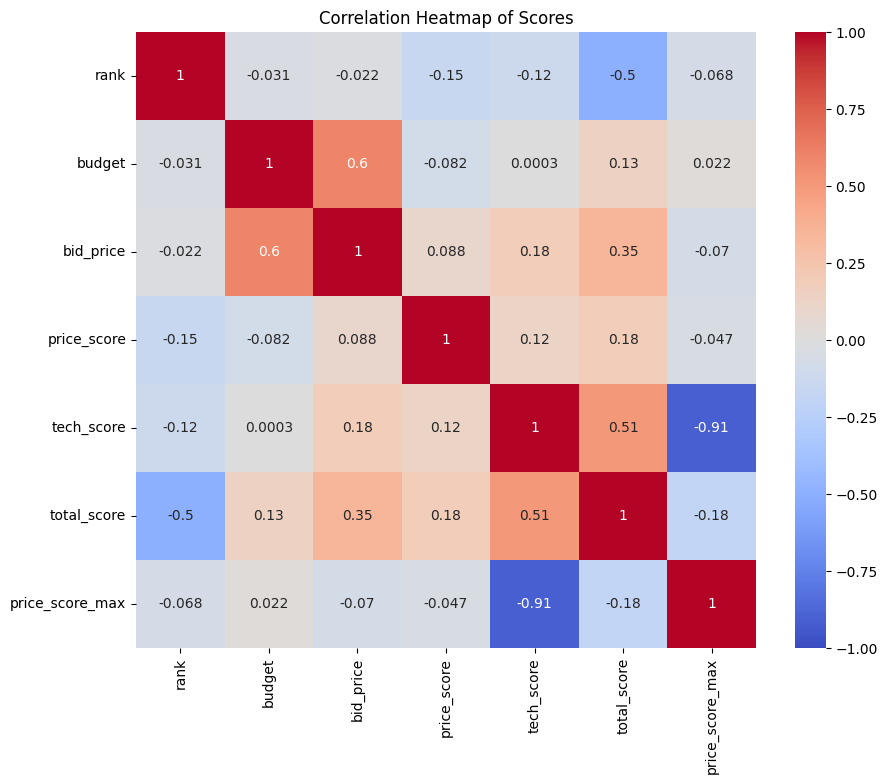

In [17]:
# 데이터 분석3 -> heatmap
numeric_cols = aicc_dataset[['rank','budget','bid_price','price_score', 'tech_score', 'total_score', 'price_score_max']]
numeric_cols_clean = numeric_cols.dropna()
corr_matrix = numeric_cols_clean.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Scores')
plt.show()

In [8]:
# competitor 컬럼 생성
def create_competitors(data):
    # competitors 리스트를 데이터셋과 동일한 크기로 생성
    competitors = pd.Series(index=data.index, dtype="object")

    # 동일한 project와 customer를 가진 회사들 그룹화
    grouped = data.groupby(['project', 'customer'])

    # 그룹핑된 데이터를 처리
    for _, group in grouped:
        if len(group) == 1:
            # 그룹에 회사가 하나만 있을 경우
            competitors.loc[group.index] = "No Competitors"
        else:
            for idx, row in group.iterrows():
                other_companies = group[group['company'] != row['company']]['company'].tolist()
                competitors.loc[idx] = ", ".join(other_companies) if other_companies else "No Competitors"

    return competitors

# competitor 컬럼 추가
aicc_dataset['competitor'] = create_competitors(aicc_dataset)

# 결과 확인
aicc_dataset[['company', 'competitor']]

,company,competitor
0,(주)이씨에스텔레콤,"(주)브리지텍, 주식회사 케이티, 주식회사 넥서스커뮤니티"
1,(주)브리지텍,"(주)이씨에스텔레콤, 주식회사 케이티, 주식회사 넥서스커뮤니티"
2,주식회사 케이티,"(주)이씨에스텔레콤, (주)브리지텍, 주식회사 넥서스커뮤니티"
3,주식회사 넥서스커뮤니티,"(주)이씨에스텔레콤, (주)브리지텍, 주식회사 케이티"
4,주식회사 솔트룩스이노베이션,No Competitors
...,...,...
137,주식회사 케이티,No Competitors
138,주식회사 마음에이아이,(주)코난테크놀로지
139,(주)코난테크놀로지,주식회사 마음에이아이
140,주식회사 리드스피커코리아,주식회사 마음에이아이


In [9]:
# 모델 사전학습용 기업별 문서 데이터
company_article = pd.read_csv('/content/drive/MyDrive/KT/AI프로토타이핑팀/company_article.csv', usecols=range(5))

In [14]:
company_article.head(1)

,no,company,date,title,content
0,1.0,주식회사 아리시스,2024-10-08,아리시스 홈페이지 (http://arisys.co.kr/solutions/%EC%8...,"AICC는 인공지능(AI, Artificial Intelligent) 기술인 음성인..."


In [10]:
# 텍스트 중 불필요한 문자 전처리
company_article['content'] = company_article['content'].astype(str).apply(lambda x: x.replace("\n", " "))

In [11]:
# KoBERT 모델과 토크나이저 로드
tokenizer = get_tokenizer()
model = get_kobert_model()
model.eval()  # 평가 모드로 전환

# Okt 형태소 분석기 로드
okt = Okt()

# 중요도 계산을 통한 키워드 추출 함수
def extract_keywords_korean(text, k=10):

    # 형태소 분석을 통해 명사만 추출
    tokens = okt.nouns(text)
    tokenized_text = ' '.join(tokens)

    # KoBERT 모델을 이용해 입력 텍스트 토크나이징
    inputs = tokenizer(tokenized_text, return_tensors='pt', padding=True, truncation=True)

    # 모델을 사용하여 문맥 임베딩 계산
    with torch.no_grad():
        outputs = model(**inputs)

    # [CLS] 토큰 벡터를 추출하여 중요도 기준
    cls_embedding = outputs.last_hidden_state[:, 0, :]

    # 각 단어의 임베딩 벡터
    word_embeddings = outputs.last_hidden_state.squeeze()

    # CLS 벡터와 단어 벡터 간 코사인 유사도 계산
    similarities = torch.cosine_similarity(word_embeddings, cls_embedding, dim=1)

    # k 값을 similarities 길이 내로 제한
    k = min(k, similarities.size(0) - 1)  # CLS 토큰 제외

    # 상위 k개의 유사도 높은 단어 인덱스를 가져오기
    top_k_indices = similarities.topk(k + 1).indices  # +1은 [CLS] 토큰을 제외하기 위해 추가

    # 상위 k개의 단어를 디코딩하여 키워드로 변환 (첫번째 CLS 토큰 제외)
    keywords = [tokenizer.decode([inputs['input_ids'][0][idx]]) for idx in top_k_indices[1:]]

    return keywords

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

tokenizer_78b3253a26.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [12]:
# 'content' 컬럼에서 키워드를 추출하여 'keywords' 컬럼에 저장
company_article['keywords'] = company_article['content'].apply(lambda x: extract_keywords_korean(x, k=30))

In [ ]:
company_article['keywords'].head(10)

,keywords
0,"[공공기관, 대한민국, 역시, 현상, 자연, 시나리오, 시나리오, 뿐, 효과, 통계..."
1,"[라며, 때문, 여러, 판단, 것, 만큼, , 지자체, 인정, 약속, 국정, 말, ..."
2,"[만큼, 대해, 더욱, 가까이, 금액, 계좌, 명의, 효과, 환경, 환경, 대한, ..."
3,"[석, 규모, 시나리오, 평균, 역량, 장점, 자연, 가지, 사회, 본인, 가입자,..."
4,"[예전, 노인, 노동, 시나리오, 만난, 본인, 본인, 고려, 성과, 혁신, 부장,..."
5,"[라며, 근본, 한편, 보이, 주주, 경영, , 계획, , 노력, , 가치, , 가..."
6,"[관측, 기계, 궁금, 자신, 대해, 당시, 더욱, 근로자, 권리, 보이, 케, 보..."
7,"[경우, 기여, 여건, 지난, 분류, 수술, 노하우, 중인, 국내, 대한, 며, 규..."
8,"[분류, 포기, 경우, 석, 석, 노하우, 노하우, 효과, 대한, 효과, 보이, 지..."
9,"[근절, 허위, 증가, 경쟁력, 며, 가치, 며, 선두, 본부장, 더욱, 기, 더욱..."


In [13]:
# 텍스트 데이터 준비 (키워드 포함)
company_texts = company_article.apply(lambda row: f"{row['content']} 키워드: {row['keywords']}", axis=1).tolist()

### 2. Llama 모델 로드 및 저장

In [14]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_use_double_quant=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.bfloat16
)

# Llama 모델과 토크나이저 로드
model = AutoModelForCausalLM.from_pretrained("MLP-KTLim/llama-3-Korean-Bllossom-8B",
                                             trust_remote_code=True, device_map="auto", quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained("MLP-KTLim/llama-3-Korean-Bllossom-8B", trust_remote_code=True)

config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

In [15]:
# LoRA 구성
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# PEFT 모델 생성
peft_model = get_peft_model(model, lora_config)

### 3. 모델 사전학습 (뉴스기사 키워드 데이터)

In [16]:
# PyTorch의 Dataset 클래스를 상속받아 사용자 정의 데이터셋을 생성
class CustomDataset(Dataset):
    def __init__(self, tokenized_inputs):
        self.input_ids = tokenized_inputs["input_ids"]
        self.attention_mask = tokenized_inputs["attention_mask"]
        self.labels = tokenized_inputs["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

In [17]:
# 전체 데이터셋을 80%는 학습용, 20%는 평가용으로 분리
train_texts, eval_texts = train_test_split(company_texts, test_size=0.2, random_state=42)

# 데이터 토크나이징
train_tokenized = tokenizer(train_texts, return_tensors='pt', padding=True, truncation=True, max_length=256)
eval_tokenized = tokenizer(eval_texts, return_tensors='pt', padding=True, truncation=True, max_length=256)

# labels 추가
train_tokenized['labels'] = train_tokenized['input_ids'].clone()
eval_tokenized['labels'] = eval_tokenized['input_ids'].clone()

# train과 eval Dataset 생성
company_dataset = CustomDataset(train_tokenized)
eval_dataset = CustomDataset(eval_tokenized)

In [ ]:
# 학습 설정
pretraining_args = TrainingArguments(
    output_dir="./pretraining_results",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    logging_dir='./logs',
    eval_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    fp16=True
)

# 트레이너 설정 및 사전학습
pretraining_trainer = Trainer(
    model=peft_model,
    args=pretraining_args,
    train_dataset=company_dataset,
    eval_dataset=eval_dataset
)

# 모델 사전학습
pretraining_trainer.train()

Step,Training Loss,Validation Loss
500,0.680100,0.404745


TrainOutput(global_step=530, training_loss=0.6654399116084261, metrics={'train_runtime': 844.2709, 'train_samples_per_second': 10.127, 'train_steps_per_second': 0.628, 'total_flos': 9.769433852962406e+16, 'train_loss': 0.6654399116084261, 'epoch': 9.906542056074766})

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,2.648900,0.531448
2,0.519000,0.448010
4,0.436800,0.416630
6,0.409200,0.401756
8,0.425300,0.401866
10,0.403700,0.403070
12,0.362300,0.404740
14,0.367800,0.405773


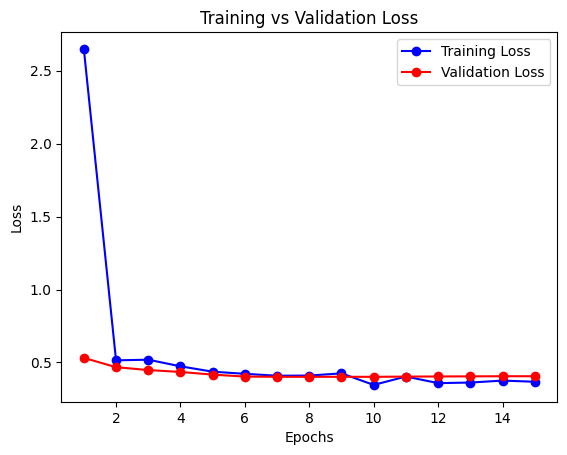

In [18]:
# 학습설정
pretraining_args = TrainingArguments(
    output_dir="./pretraining_results",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=15,
    logging_dir='./logs',
    eval_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    fp16=True,  # Mixed Precision Training
    logging_steps=50,  # 몇 번의 스텝마다 로그를 기록할지
    evaluation_strategy="epoch"  # 에포크가 끝날 때마다 검증 수행
)

# 트레이너 설정 및 사전학습
pretraining_trainer = Trainer(
    model=peft_model,
    args=pretraining_args,
    train_dataset=company_dataset,
    eval_dataset=eval_dataset
)

# 모델 사전학습
training_logs = pretraining_trainer.train()

# 손실 값 추출
training_losses = [log['loss'] for log in pretraining_trainer.state.log_history if 'loss' in log]
validation_losses = [log['eval_loss'] for log in pretraining_trainer.state.log_history if 'eval_loss' in log]

# 에포크 또는 스텝 범위 지정
epochs = range(1, len(training_losses) + 1)

# 손실값 시각화
plt.plot(epochs, training_losses, 'bo-', label='Training Loss')  # 'bo-'는 파란색 점과 선
plt.plot(epochs, validation_losses, 'ro-', label='Validation Loss')  # 'ro-'는 빨간색 점과 선

# 그래프의 제목과 라벨 설정
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

### 4. 회귀모델과의 결합(조달청 데이터)

In [1]:
# 입력 변수와 레이블 준비
X = aicc_dataset[['category', 'project', 'customer', 'company', 'rank', 'budget', 'bid_price', 'price_score', 'tech_score', 'price_score_max', 'competitor']]
y = aicc_dataset['total_score']

# 수치형 변수만 선택
numerical_features = ['rank', 'budget', 'bid_price', 'price_score', 'tech_score', 'price_score_max']

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# X 데이터 스케일링
X[numerical_features] = scaler.fit_transform(X[numerical_features])

NameError: name 'aicc_dataset' is not defined

1. CountVectorizer
- 텍스트 데이터를 벡터화 하는데 일반적으로 활용됨
2. TfidfVectorizer
- 단순 빈도 기반이 아닌, 각 단어의 중요도를 반영하여 벡터화
- 자주 등장하는 불필요한 단어(예: "the", "and")에 가중치를 낮추어 더 유의미한 특징을 학습할 수 있다
3. HashingVectorizer
- 메모리 효율이 좋아 대용량 데이터 처리에 적합
4. Word2Vec
- 주로 문맥을 기반으로 단어를 벡터화하며, 사전 학습된 모델을 사용가능 (경량화에 강점이 있다)
5. FastText
- 단어의 서브워드(subword)를 학습하여 유사한 단어들의 벡터를 더 잘 표현 (OOV(Out-Of-Vocabulary) 문제에 강하다)
- 단어의 내부 구조를 학습하는 데 초점
6. BERT Embedding
- 문장의 문맥을 이해하며, 각 단어의 의미를 그 주변 문맥에 따라 다르게 표현할 수 있는 트랜드 모델

In [ ]:
# 텍스트 데이터 준비 및 벡터화
text_features = X[['category', 'project', 'customer', 'company', 'competitor']].astype(str).agg(' '.join, axis=1)

# Count Vectorization (토큰별 빈도, 패턴을 회귀모델이 학습)
vectorizer = CountVectorizer()
text_features_vectorized = vectorizer.fit_transform(text_features)

# DataFrame으로 변환
text_features_df = pd.DataFrame(text_features_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# 기존 데이터프레임에서 벡터화한 텍스트 컬럼은 제거하고, 벡터화된 텍스트 데이터와 결합
X = pd.concat([X.drop(columns=['category', 'project', 'customer', 'company', 'competitor']).reset_index(drop=True),
               text_features_df.reset_index(drop=True)], axis=1)

In [ ]:
# 데이터셋을 학습용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 선형 회귀 모델 학습
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 랜덤 포레스트 회귀 모델 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost 회귀 모델 학습
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 모델 평가 함수 정의
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [ ]:
# 평가
linear_rmse, linear_r2 = evaluate_model(linear_model, X_test, y_test)
rf_rmse, rf_r2 = evaluate_model(rf_model, X_test, y_test)
xgb_rmse, xgb_r2 = evaluate_model(xgb_model, X_test, y_test)

# 결과 출력
print("Linear Regression: RMSE =", linear_rmse, ", R2 =", linear_r2)
print("Random Forest: RMSE =", rf_rmse, ", R2 =", rf_r2)
print("XGBoost: RMSE =", xgb_rmse, ", R2 =", xgb_r2)

Linear Regression: RMSE = 241033592282.57977 , R2 = -2.18868878778311e+21
Random Forest: RMSE = 1.73907688066069 , R2 = 0.8860625672797362
XGBoost: RMSE = 1.953902568486706 , R2 = 0.8561749035547367


In [ ]:
# 종합평점 예측 함수
def predict_total_score(input_data):
    # 범주형 텍스트 피처를 CountVectorizer
    text_features = input_data[['category', 'project', 'customer', 'company', 'competitor']].astype(str).agg(' '.join, axis=1)
    text_features_vectorized = vectorizer.transform(text_features)
    text_features_df = pd.DataFrame(text_features_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

    # 수치형 데이터 스케일링
    numerical_features = ['rank', 'budget', 'bid_price', 'price_score', 'tech_score', 'price_score_max']
    input_data[numerical_features] = scaler.transform(input_data[numerical_features])

    # 최종 입력 데이터 생성
    X_input = pd.concat([input_data[numerical_features].reset_index(drop=True), text_features_df.reset_index(drop=True)], axis=1)
    X_input = X_input.reindex(columns=X_train.columns, fill_value=0)

    # 모델 예측
    return round(rf_model.predict(X_input)[0], 3)

### 5. 프롬프트 엔지니어링

In [ ]:
# 주요 입력 데이터를 준비하는 함수
def prepare_input_data(company, competitor, project, category, budget, customer):
    return pd.DataFrame({
        'category': [category],
        'project': [project],
        'customer': [customer],
        'company': [company],
        'competitor': [competitor],
        'rank': [0],
        'budget': [float(budget)],
        'bid_price': [0],
        'price_score': [0],
        'tech_score': [0],
        'price_score_max': [10]
    })

# 각 생성 함수의 공통 설정 매개변수 조정
generation_args = {
    "temperature": 0.8,
    "do_sample": True,
    "repetition_penalty": 1.1,
    "top_p": 0.85,
    "max_new_tokens": 700
}

In [ ]:
# 각 생성 함수의 공통 설정 매개변수 조정
generation_args = {
    "temperature": 0.8,
    "do_sample": True,
    "repetition_penalty": 1.1,
    "top_p": 0.85,
    "max_new_tokens": 800
}

In [ ]:
# 공격/방어 전략 함수
def generate_aggressive_or_defensive_strategy(company, competitors, project, category, customer):
    competitors_list = ', '.join(competitors)
    prompt = f"""
    {company}는 {competitors_list}와 {project} 사업에서 경쟁 중입니다.
    {company}가 이 프로젝트에서 수주 가능성을 극대화하기 위한 최적의 전략을 제안해 주세요.
    """
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=300).to(device)
    outputs = peft_model.generate(**inputs, **generation_args)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):].strip()

# 차별화 전략 함수
def generate_differentiation_suggestion(company, competitors, project, category, customer):
    competitors_list = ', '.join(competitors)
    prompt = f"""
    {company}는 {competitors_list}와 {project} 사업에서 경쟁 중입니다.
    {company}가 경쟁 우위를 선점할 수 있는 차별화 전략을 제안해 주세요.
    """
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=300).to(device)
    outputs = peft_model.generate(**inputs, **generation_args)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):].strip()

# 경쟁사 기사 요약 함수
def get_relevant_article_keywords(company_name):
    keywords = company_article[company_article['company'] == company_name]['keywords'].values
    return keywords[0] if len(keywords) > 0 else ""

def generate_competitor_article_summary(company):
    keywords = get_relevant_article_keywords(company)
    competitors_list = ', '.join(competitors)
    prompt = f"""
    주요 키워드: {keywords}
    {company}의 {competitors_list}의 최신 기술 동향을 요약해 주세요.
    """
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=300).to(device)
    outputs = peft_model.generate(**inputs, **generation_args)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):].strip()

In [ ]:
# 선택한 함수에 따라 호출할 생성 함수 매핑
generate_functions = {
    "공격 또는 방어 전략": generate_aggressive_or_defensive_strategy,
    "차별화 전략": generate_differentiation_suggestion,
    "경쟁사 기사 요약": lambda company, competitors, project, category, customer: generate_competitor_article_summary(company),
}

# 기본 응답과 선택된 생성 함수 실행을 포함하는 메인 함수
def predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function):
    if isinstance(competitors, str):
        competitors = [competitors]

    competitor_scores = {comp: predict_total_score(prepare_input_data(comp, company, project, category, budget, customer)) for comp in competitors}
    company_predicted_score = predict_total_score(prepare_input_data(company, None, project, category, budget, customer))

    total_scores = list(competitor_scores.values()) + [company_predicted_score]
    company_rank = sorted(total_scores, reverse=True).index(company_predicted_score) + 1

    position = ("우위" if company_rank <= len(total_scores) / 3 else
                "동등" if company_rank <= 2 * len(total_scores) / 3 else "열위")

    competitors_scores_str = ', '.join([f"{comp}: {score:.2f}" for comp, score in competitor_scores.items()])
    basic_response = f"""
    {company}는 {', '.join(competitors)}와 {project} 프로젝트에서 경쟁 중입니다.
    고객사: {customer}
    예상 프로젝트 예산: {budget} 원
    각 경쟁자의 예상 종합평점: {competitors_scores_str}
    {company}의 예상 종합평점은 {company_predicted_score:.2f}입니다.
    최근 입찰 결과를 기준으로 {company}의 위치는 **{position}**로 판단됩니다.
    """

    # 선택한 생성 함수 실행
    additional_response = ""
    if selected_generation_function in generate_functions:
        generation_func = generate_functions[selected_generation_function]
        additional_response = generation_func(company, competitors, project, category, customer)

    return basic_response, additional_response

In [ ]:
# 테스트 파라미터 설정
company = "주식회사 케이티"
competitors = ["(주)이씨에스텔레콤", "(주)브리지텍"]
project = "AI기반 스마트 컨택센터 구축사업 입찰 시행"
category = "AICC"
budget = "2530000000"
customer = "대한지방행정공제회"

# 테스트#1
selected_generation_function = "공격 또는 방어 전략"
basic_response, specific_response = predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function)

# 결과 출력
print("기본 응답:")
print(basic_response)
print(f"\n{selected_generation_function}:")
print(specific_response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


기본 응답:

    주식회사 케이티는 (주)이씨에스텔레콤, (주)브리지텍와 AI기반 스마트 컨택센터 구축사업 입찰 시행 프로젝트에서 경쟁 중입니다.
    고객사: 대한지방행정공제회
    예상 프로젝트 예산: 2530000000 원
    각 경쟁자의 예상 종합평점: (주)이씨에스텔레콤: 82.90, (주)브리지텍: 83.09
    주식회사 케이티의 예상 종합평점은 83.09입니다.
    최근 입찰 결과를 기준으로 주식회사 케이티의 위치는 **우위**로 판단됩니다.
    

공격 또는 방어 전략:
[이름] 케이티 AI시스템사업팀장은 "케이티는 인공지능(AI) 기반의 스마트 컨택센터 구축사업에 역량을 집중하고 있다"며 "현재 AICC(인공지능기반 콜센터), IVR(자동응답기), 챗봇 등의 기술로 고객에게 높은 서비스를 제공할 수 있는 솔루션을 개발해왔다"고 설명했다. 
  이번에는 ▲AICC 기술을 확보한 ▲IVR 시스템의 기능 강화를 ▲챗봇 솔루션을 개선 ▲콜백형 챗봇을 도입하는 등 △전통 콜센터의 업그레이드를 통한 △AI기반 컨택센터 솔루션을 통한 △스마트 컨택센터 구축사업에 필요한 모든 기술을 갖추고 있다고 밝혔다.  
  이어 “지난해까지 상담시간이 연장되거나 부족하는 문제가 발생했지만, 현재 상담시간은 적절하게 유지되고 있으며 상담사원과 상담내용을 관리하는 데 활용될 수 있는 시스템을 구축하고 있다”고 덧어 말했다.  
  올해는 코로나19 팬데믹으로 인해 전화상담이 증가했지만, 오픈 채팅상담이 늘면서 상담 시간이 단축되는 추세다. 이러한 상황에서 AI기반 콜센터를 통해 상담시간을 단축하고 효율적으로 운영하고자 한다.  
  특히 최근 아프리카가 출시한 채팅 플랫폼 'TALK'의 채팅상담 내역이 지속적으로 증가하며 상담원에게 많은 부담이 작용하고 있어 효율적인 상담 시스템을 요구받고 있다.  
  최근 AICC 기술을 통해 기업들이 클릭·콜·채팅상담을 통합하여 관리할 수 있게 되었다. 상담원에 대한 추가 교육도 필요하지 않으며, 상담 사전 예약

In [ ]:
# 테스트#2
selected_generation_function = "차별화 전략"
basic_response, specific_response = predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function)

# 결과 출력
print("기본 응답:")
print(basic_response)
print(f"\n{selected_generation_function}:")
print(specific_response)

In [ ]:
# 테스트#3
selected_generation_function = "경쟁사 기사 요약"
basic_response, specific_response = predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function)

# 결과 출력
print("기본 응답:")
print(basic_response)
print(f"\n{selected_generation_function}:")
print(specific_response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


기본 응답:

    주식회사 케이티는 (주)이씨에스텔레콤, (주)브리지텍와 AI기반 스마트 컨택센터 구축사업 입찰 시행 프로젝트에서 경쟁 중입니다.
    고객사: 대한지방행정공제회
    예상 프로젝트 예산: 2530000000 원
    각 경쟁자의 예상 종합평점: (주)이씨에스텔레콤: 82.90, (주)브리지텍: 83.09
    주식회사 케이티의 예상 종합평점은 83.09입니다.
    최근 입찰 결과를 기준으로 주식회사 케이티의 위치는 **우위**로 판단됩니다.
    

경쟁사 기사 요약:
1. 시나리오에 석규모 인공지능(이하 'AIC') 기반 'AI 학습 콘텐츠' 개발 완료
        AIC는 'AI 인공지능 콘텐츠'입니다.  
     2. 본인 가입자의 평균 학습시간 확대 목표
        개인의 가입자와 참여자가 많은 경우, 평균 학습시간을 늘리는 것이 중요합니다.  
     3. 사회적 연대사업을 위해 공동 결제기 결합 추진
        개별적으로 진행하고 있는 사업들을, 사회적 연대사업으로 통합하는 방안을 검토하고 있습니다.  
     4. 학습 콘텐츠 위한 약속
        최근 학습 콘텐츠에 대한 관심이 높습니다.  
     5. 컨퍼런스 개최 및 개설 과정 도우기 준비
        향후 컨퍼런스를 기획하고, 관련 콘텐츠를 제공할 계획입니다.  
     6. 다양한 학습 환경을 제공하는 훈련 방안 구축
        다양한 학습 환경과 방식을 제공하여, 학습에 필요한 조건을 갖추게 하겠습니다.  
     7. 기업 간 AI 학습 콘텐츠 제공을 위한 협력 관계 형성
        기업 간 협력을 통해, 다양한 콘텐츠를 제공하기로 했습니다.  
     8. 공동으로 학습 플랫폼을 개발할 예정
        양사는 공동으로 학습 플랫폼을 개발할 계획입니다.  
     9. 교육 컨설팅 서비스 제공을 위한 상담회 진행
        상담회를 통해, 고객의 학습 방침과 필요에 맞는 서비스를 제공하려고 합니다.  
   

In [ ]:
# 테스트 파라미터 설정
company = "주식회사 케이티"
competitors = ["주식회사 아리시스", "주식회사 아이브릭스"]
project = "AI기반 스마트 컨택센터 구축사업 입찰 시행"
category = "AICC"
budget = "1650000000"
customer = "공무원연금관리공단"

# 테스트#1
selected_generation_function = "공격 또는 방어 전략"
basic_response, specific_response = predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function)

# 결과 출력
print("기본 응답:")
print(basic_response)
print(f"\n{selected_generation_function}:")
print(specific_response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


기본 응답:

    주식회사 케이티는 주식회사 아리시스, 주식회사 아이브릭스와 AI기반 스마트 컨택센터 구축사업 입찰 시행 프로젝트에서 경쟁 중입니다.
    고객사: 공무원연금관리공단
    예상 프로젝트 예산: 1650000000 원
    각 경쟁자의 예상 종합평점: 주식회사 아리시스: 82.94, 주식회사 아이브릭스: 82.90
    주식회사 케이티의 예상 종합평점은 82.83입니다.
    최근 입찰 결과를 기준으로 주식회사 케이티의 위치는 **열위**로 판단됩니다.
    

공격 또는 방어 전략:
기업명 : 주식회사 케이티 [대표] 강원우 [업종] 통신/IT [설립일] 1993년 11월 12일 [위치] 서울 동작구 왕십로4길 121, 신세타워 13층, 1301호 [전화번호] 02-3445-1111~2 [팩스번호] 02-3445-1119 [이메일] krkt@krkt.com


In [ ]:
# 테스트#2
selected_generation_function = "차별화 전략"
basic_response, specific_response = predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function)

# 결과 출력
print("기본 응답:")
print(basic_response)
print(f"\n{selected_generation_function}:")
print(specific_response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


기본 응답:

    주식회사 케이티는 주식회사 아리시스, 주식회사 아이브릭스와 AI기반 스마트 컨택센터 구축사업 입찰 시행 프로젝트에서 경쟁 중입니다.
    고객사: 공무원연금관리공단
    예상 프로젝트 예산: 1650000000 원
    각 경쟁자의 예상 종합평점: 주식회사 아리시스: 82.94, 주식회사 아이브릭스: 82.90
    주식회사 케이티의 예상 종합평점은 82.83입니다.
    최근 입찰 결과를 기준으로 주식회사 케이티의 위치는 **열위**로 판단됩니다.
    

차별화 전략:
[전문] 1. 전략제안: 업계 최초로 'AI 기반 스마트 컨택센터'를 구축하고 있습니다. 이를 통해 고객 서비스 품질을 높이고 운영 효율성을 향상시키며, 기업가치 상승을 도모하는 새로운 모델을 제시합니다. 2. 인프라 관리: AI 기반 스마트 컨택센터의 주요 특징은 AI 기술에 의한 전화응대 자동화입니다. 이 시스템은 고객 호출에 대해 응답하거나, 상담요청 정보를 저장하며, 콜백 기능도 제공합니다. 3. 인력 지원: 현재는 인공지능이 고객과 대화를 주고받습니다. 고객의 궁금증이나 불편함을 빠르게 해결하기 위해 전문상담원이 즉시 상담으로 전환합니다. 4. 데이터 분석: 고객의 통신내용을 데이터베이스에 저장하여 분석합니다. 이를 통해 고객 행동 및 선호도를 파악할 수 있으며, 이를 바탕으로 맞춤형 서비스를 제공합니다. 5. 모바일 앱 서비스: 스마트폰 앱 서비스를 통해 고객이 원하는 정보나 상담 내용을 확인할 수 있습니다. 또한, 상담신청 시 SMS 또는 문자메시지를 받을 수 있습니다. 6. 연동 시스템: 고객 정보와 상담내역을 다른 시스템에 저장합니다. 다양한 시스템과 연동하여 사용자 정보를 저장 및 관리합니다. 7. 상담기록: 고객과의 대화를 녹취하고, 녹취된 음성 파일을 녹취된 음성파일 형태로 저장합니다. 상담내용을 문서화하여 저장합니다. 8. 지인비 0%: 상담을 통해 발생되는 모든 결제수익에 대한 지인비를 부담하지 않습니다. 9. 상담소유지: 자체 소유의

In [ ]:
# 테스트#3
selected_generation_function = "경쟁사 기사 요약"
basic_response, specific_response = predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function)

# 결과 출력
print("기본 응답:")
print(basic_response)
print(f"\n{selected_generation_function}:")
print(specific_response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


기본 응답:

    주식회사 케이티는 주식회사 아리시스, 주식회사 아이브릭스와 AI기반 스마트 컨택센터 구축사업 입찰 시행 프로젝트에서 경쟁 중입니다.
    고객사: 공무원연금관리공단
    예상 프로젝트 예산: 1650000000 원
    각 경쟁자의 예상 종합평점: 주식회사 아리시스: 82.94, 주식회사 아이브릭스: 82.90
    주식회사 케이티의 예상 종합평점은 82.83입니다.
    최근 입찰 결과를 기준으로 주식회사 케이티의 위치는 **열위**로 판단됩니다.
    

경쟁사 기사 요약:
- 2022년 4월 19일
   1. 네이버 클라우드와 시나리오, KT는 자발성 기반 AI 인공지능 학습 플랫폼 구축 계약을 체결했다고 20일 밝혔다.  
   2. KT는 최근 AI 학습 플랫폼과 AI 학습 솔루션을 확보한 기업에 대한 2023년 5월 31일까지의 5월 중순까지 구축 완료하는 계약을 체결했다고 밝혔다.  
   3. 2020년 11월 30일, 시나리오는 한국경제신문에 ABR(아트브레인제) 관련 기사를 올린 바 있다.  해당 기사는 시나리오의 ABR 제휴 계약이 끝난 후 고객이 수억 원의 손실을 보았다고 전하며 KT의 ABR 제휴 계약으로 인해 KT의 ABR 제휴 계약이 종료된 후 시나리오의 ABR 제휴 계약도 종료된 것임을 알렸었다.  
   4. KT는 2023년 6월 12일부터 13일까지 서울 코엑스에서 열리는 2023년 한국 ICT관광전을 개최한다고 밝혔다.  
   5. KT는 2023년 6월 15일부터 16일까지 대구 컨벤션센터에서 열리는 2023년 대구국제ICT구매전을 개최한다고 밝혔다.  
   6. KT는 2023년 7월 17일부터 21일까지 부산 BEXCO에서 열리는 2023년 한국 국제정보통신기술(ICT)거래회사를 개최한다고 밝혔다.  
   7. KT는 2023년 8월 22일부터 25일까지 제주 컨벤션센터에서 열리는 제주국제 ICT구매전을 개최한다고 밝혔다.  
   8. KT는 2023년 9월 26일부터 29일까지 

### 6. Gradio UI 구현

In [ ]:
# Gradio 인터페이스 설정(매 submit마다 독립 시행, 이전 응답 초기화)
def reset_responses():
    return "", ""

def main(company, competitors, project, category, budget, customer, selected_generation_function):
    return predict_and_generate_report(company, competitors, project, category, budget, customer, selected_generation_function)

# Gradio 인터페이스 정의
iface = gr.Interface(
    fn=main,
    inputs=[
        gr.Textbox(label="회사명"),
        gr.Dropdown(label="경쟁업체 목록", choices=list(aicc_dataset['company'].unique()), multiselect=True),
        gr.Textbox(label="사업명"),
        gr.Textbox(label="상품"),
        gr.Textbox(label="사업예산 (숫자로 입력)"),
        gr.Textbox(label="고객사"),
        gr.Radio(["공격 또는 방어 전략", "차별화 전략", "경쟁사 기사 요약"], label="생성할 전략 선택")
    ],
    outputs=[
        gr.Textbox(label="종합평점 및 경쟁우위 예측 결과"),
        gr.Textbox(label="선택한 보고서 생성 결과")
    ],
    title="KT 입찰 AI",
    description="특정 전략을 선택하여 공격/방어 전략, 차별화 전략 또는 경쟁사 기사 요약을 생성합니다."
)

# Gradio 앱 실행
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://46656a1c0131b1bc5d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
